In [45]:
import math
import pandas as pd
import numpy as np
import csv
import os
import glob
import matplotlib.pyplot as plt


global T1
T1 = 0.00005
global T2
T2 = 0.00025
global T3
T3= 0.00045

global Dlen
Dlen = 0

global SW1Index
SW1pt = [0,0]
global SW2Index
SW2pt = [0,0]

global MOSFET 
MOSFET = [0,0,0,0]#Eon,Eoff,Conduction,index

global BodyDiode
BodyDiode = [0,0,0]#Eon,Eoff,Conduction,index

global k
k = 3



In [46]:
def getFileList():
    path = "./"
    file_list = os.listdir(path)
    file_list_txt = [file for file in file_list if file.endswith(".txt")]
    print(file_list_txt)
    
    FL = file_list_txt
    FL.sort()
    
    FL.remove('cases.txt')
    
    return FL


    
fileList = getFileList()

print(fileList)


['T125V020I030_data.txt', 'T025V030I030_data.txt', 'T125V035I030_data.txt', 'T125V035I050_data.txt', 'T125V020I050_data.txt', 'T025V030I050_data.txt', 'T025V030I020_data.txt', 'T125V020I020_data.txt', 'T125V035I020_data.txt', 'T025V020I010_data.txt', 'T125V035I040_data.txt', 'T125V030I010_data.txt', 'T025V030I040_data.txt', 'T025V035I010_data.txt', 'T125V020I040_data.txt', 'T125V030I040_data.txt', 'T125V035I010_data.txt', 'T025V020I040_data.txt', 'T125V020I010_data.txt', 'T025V035I040_data.txt', 'T025V030I010_data.txt', 'cases.txt', 'T025V035I020_data.txt', 'T125V030I020_data.txt', 'T025V020I020_data.txt', 'T025V020I050_data.txt', 'T125V030I050_data.txt', 'T025V035I050_data.txt', 'T025V035I030_data.txt', 'T025V020I030_data.txt', 'T125V030I030_data.txt']
['T025V020I010_data.txt', 'T025V020I020_data.txt', 'T025V020I030_data.txt', 'T025V020I040_data.txt', 'T025V020I050_data.txt', 'T025V030I010_data.txt', 'T025V030I020_data.txt', 'T025V030I030_data.txt', 'T025V030I040_data.txt', 'T025V030I

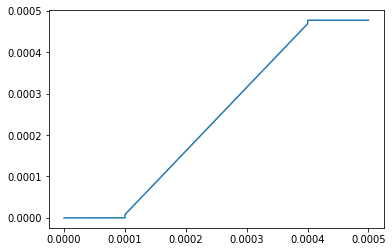

In [48]:
def getDataCol(data, index):
    dfile = pd.read_csv(data,delimiter = '\t')
    column_data = dfile.loc[:,dfile.columns[index]]
    return column_data



t_data = getDataCol(fileList[1],0)
P_data = getDataCol(fileList[1],4)


plt.plot(t_data,P_data)




In [49]:
def getTimeRef(data):
    flag = 0
    length = data.__len__()
    print(len(data))
    for i in range(0,len(data)):
        if data[i] > T1:
            T1index = i
            break
    for i in range(0,len(data)):
        if data[i] > T2:
            T2index = i
            break        
    for i in range(0,len(data)):
        if data[i] > T3:
            T3index = i
            break
    
    output = [T1index,T2index,T3index]
    return output

TIME = getDataCol(fileList[5],0)
P1 = getDataCol(fileList[5],3)
E1 = getDataCol(fileList[5],4)
E2 = getDataCol(fileList[5],8)



Tindex = getTimeRef(TIME)


print(Tindex)
print(TIME[Tindex[0]])
print(TIME[Tindex[1]])
print(TIME[Tindex[2]])
    

1192
[12, 681, 1186]
5.280000000000001e-05
0.0002544542470706
0.0004541329369559


In [50]:
def getRefValQ1(TIME_INDEX, TIME_DATA, V_DATA, E_DATA, P_DATA):
    
    T1avg = (V_DATA[TIME_INDEX[0]-2]+V_DATA[TIME_INDEX[0]-1]+V_DATA[TIME_INDEX[0]]+V_DATA[TIME_INDEX[0]+1]+V_DATA[TIME_INDEX[0]+2])/5
    T2avg = (V_DATA[TIME_INDEX[1]-2]+V_DATA[TIME_INDEX[1]-1]+V_DATA[TIME_INDEX[1]]+V_DATA[TIME_INDEX[1]+1]+V_DATA[TIME_INDEX[1]+2])/5 
    ##T2avg = (P_DATA[TIME_INDEX[1]-2]+P_DATA[TIME_INDEX[1]-1]+P_DATA[TIME_INDEX[1]]+P_DATA[TIME_INDEX[1]+1]+P_DATA[TIME_INDEX[1]+2])/5
    T2Eslope = ( E_DATA[TIME_INDEX[1]+1]-E_DATA[TIME_INDEX[1]] ) /(TIME_DATA[TIME_INDEX[1]+1]-TIME_DATA[TIME_INDEX[1]])
    T3avg = (E_DATA[TIME_INDEX[2]-1]+E_DATA[TIME_INDEX[2]]+E_DATA[TIME_INDEX[2]+1])/3
    
    T2bias = E_DATA[TIME_INDEX[1]]-(T2Eslope*TIME_DATA[TIME_INDEX[1]])
    
    RefVal = [T1avg, T2Eslope, T2bias, T3avg]
      
    return RefVal

TIME = getDataCol(fileList[5],0)
P1 = getDataCol(fileList[5],3)
E1 = getDataCol(fileList[5],4)
V1 = getDataCol(fileList[5],1)
I1 = getDataCol(fileList[5],2)
E2 = getDataCol(fileList[5],8)
V2 = getDataCol(fileList[5],5)
datalen = len(TIME)

                                                                
RefVal = getRefValQ1(Tindex, TIME, V1, E1, P1)
       
T2_VAL = RefVal[1]*TIME[Tindex[1]+1]+RefVal[2]  


print(RefVal[1])
print(RefVal[2])


                                                              
                                                                                                                                                    

0.38301322175880387
-3.2442776681058374e-05


In [51]:
##Using differentiation to get slope and intercept of each time sector
#getTrend returns A,B value which represent slope and intercept of trend equation(y = Ax+B)

def getTrend(trefpt, data, time,  ptnum = 3):
    
    slope=[]
    intercept=[]
    error = []
    
    A = 0
    B = 0

    datalen = ptnum*2+1
    
    for i in range(trefpt-ptnum, trefpt+ptnum):
        slope.append((data[i]-data[i-1])/(time[i]-time[i-1]))
    A = sum(slope)/len(slope)
    
    for i in range(trefpt-ptnum, trefpt+ptnum):
        intercept.append(data[i] - time[i]*A)        
    B = sum(intercept)/len(intercept)
    
    for i in range(trefpt-ptnum, trefpt+ptnum):
        error.append(abs(data[i] - (A*time[i]+B)))
    
    ERROR = sum(error)/len(error)
    return [A, B, ERROR]


E1trendT1 = getTrend(Tindex[0], E1, TIME, 5)     
E1trendT2 = getTrend(Tindex[1], E1, TIME, 5)
E1trendT3 = getTrend(Tindex[2], E1, TIME, 5) 

E2trendT1 = getTrend(Tindex[0], E2, TIME, 5)     
E2trendT2 = getTrend(Tindex[1], E2, TIME, 5)
E2trendT3 = getTrend(Tindex[2], E2, TIME, 5)

V2trendT1 = getTrend(Tindex[0], V2, TIME, 5)

print(E1trendT2[0])
print(E1trendT2[1])
print(E1trendT2[2])



print(" ")
print(E2trendT1[0]*TIME[Tindex[0]]+E2trendT1[1])
print(E2[Tindex[0]])

print(E2[Tindex[0]]-(E2trendT1[0]*TIME[Tindex[0]]+E2trendT1[1]))
print(E2trendT1[2])

print((E2[Tindex[0]]-(E2trendT1[0]*TIME[Tindex[0]]+E2trendT1[1]))/(E2trendT1[2]))

0.3830158211375591
-3.2443447087358964e-05
9.081417461429117e-12
 
0.00043012295458503657
0.000430122954585
-3.6591823321385775e-17
3.0977011320626466e-17
-1.181257382858643


In [58]:
#Using average error ratio. coeff means multiple of k 
def getSwitchPt1(trefpt1, trefpt2, trend, data, time, mark, coeff = k):
    for i in range(trefpt1, trefpt2):
        error = abs(data[i]-(trend[0]*time[i]+trend[1]))
        #print(error/trend[2])
        #print(trend[2])
        #print(error)
        #print(i)
        #print("")
        if ((error/trend[2]) < coeff) & (mark == 0):
            return i
        elif ((error/trend[2]) > coeff) & (mark == 1):
            return i
        
#Using difference ratio. coeff means difference percentage       
def getSwitchPt2(trefpt1, trefpt2, trend, data, time, mark, coeff = k):
    for i in range(trefpt1, trefpt2):
        ratio = 100 - abs(data[i]/(trend[0]*time[i]+trend[1])*100)
        #print((data[i]/(trend[0]*time[i]+trend[1])*100))
        #print(ratio)
        #print("")
        if (ratio < coeff) & (mark == 0):
            return i
        elif (ratio > coeff) & (mark == 1):
            return i

#Using differenciation to get slope. coeff means difference percentage       
def getSwitchPt3(trefpt1, trefpt2, trend, data, time, mark, coeff = k):
    for i in range(trefpt1, trefpt2):
        slope = (data[i]-data[i+1])/(time[i]-time[i+1])
        #print(slope)
        #print(trend[0])
        #print(100-(abs((slope/trend[0])*100)))
        #print("")
        if ((abs(100-abs((slope/trend[0])*100)) < coeff) & (mark == 0)):
            return i
        elif ((abs(100-abs((slope/trend[0])*100)) > coeff) & (mark == 1)):
            return i        
        
SW1pt[0] = getSwitchPt1(Tindex[0], Tindex[1], E1trendT1, E1, TIME,1)        
SW1pt[1] = getSwitchPt2(Tindex[0], Tindex[1], E1trendT2, E1, TIME,0)       
SW2pt[0] = getSwitchPt1(Tindex[1], Tindex[2], E1trendT2, E1, TIME,1)
SW2pt[1] = getSwitchPt1(SW2pt[0], Tindex[2], E1trendT3, E1, TIME,0)
Q2pt = getSwitchPt3(Tindex[0], Tindex[1], E2trendT1, E2, TIME, 1, 6 )
print(SW1pt[0])
print(SW1pt[1])
print(SW2pt[0])
print(SW2pt[1])

print(Q2pt)


print(TIME[SW1pt[0]])
print(TIME[SW1pt[1]])

print(TIME[SW2pt[0]])
print(TIME[SW2pt[1]])

17
57
699
824
26
0.0001
0.0001001438243612
0.0004000626
0.0004002791647424


In [54]:
def getTestCondition(file):
    sub = "_data.txt"
    #row = len(filelist[0])-9
    #col = len(filelist)-1
    
    fileSub = []
    FILE = []
    
    #fileTitles = np.zeros((col,row))
    

    fileSub = ( [x for x in file if x not in sub] )
    
    temperature = float(fileSub[1])*100 + float(fileSub[2])*10+float(fileSub[3])
    voltage = float(fileSub[5])*100 + float(fileSub[6])*10+float(fileSub[7])
    current = float(fileSub[9])*100 + float(fileSub[10])*10+float(fileSub[11])
        
    FILE.append(temperature)
    FILE.append(voltage)
    FILE.append(current)
    FILE.append(index)
    return FILE

FILES = getTestCondition(fileList[0])

print(FILES[0])
print(FILES[1])
print(FILES[2])

    #f = open('data.csv', 'w', encoding='utf-8', newline='')
    #wr = csv.writer(f)
    #wr.writerow(fileListSub)

25.0
20.0
10.0


In [40]:
fileList = getFileList()
fileNum = len(fileList)

tempcnd = []
currcnd = []
voltcnd = []



for i in range(0,fileNum-1):
    testcnd = getTestCondition(fileList[i])
    
    tempcnd.append(testcnd[0])
    voltcnd.append(testcnd[1])
    currcnd.append(testcnd[2])
    
    

for i in range(0,fileNum-1):
    TIME = getDataCol(fileList[i],0)
    V1 = getDataCol(fileList[i],1)
    I1 = getDataCol(fileList[i],2)
    P1 = getDataCol(fileList[i],3)
    E1 = getDataCol(fileList[i],4)
    V2 = getDataCol(fileList[i],5)
    I2 = getDataCol(fileList[i],6)
    P2 = getDataCol(fileList[i],7)
    E2 = getDataCol(fileList[i],8)
    
    TimeRef = getTimeRef(TIME)
    
    TC = getTestCondition(fileList[i])
    
    E1trendT1 = getTrend(TimeRef[0], E1, TIME, 5)     
    E1trendT2 = getTrend(TimeRef[1], E1, TIME, 5)
    E1trendT3 = getTrend(TimeRef[2], E1, TIME, 5) 

    E2trendT1 = getTrend(TimeRef[0], E2, TIME, 5)     
    E2trendT2 = getTrend(TimeRef[1], E2, TIME, 5)
    E2trendT3 = getTrend(TimeRef[2], E2, TIME, 5)

    V2trendT1 = getTrend(TimeRef[0], V2, TIME, 5)
    
    SW1pt[0] = getSwitchPt1(TimeRef[0], TimeRef[1], E1trendT1, E1, TIME,1)        
    SW1pt[1] = getSwitchPt2(TimeRef[0], TimeRef[1], E1trendT2, E1, TIME,0)       
    SW2pt[0] = getSwitchPt1(TimeRef[1], TimeRef[2], E1trendT2, E1, TIME,1)
    SW2pt[1] = getSwitchPt1(SW2pt[0], TimeRef[2], E1trendT3, E1, TIME,0)
    Q2pt = getSwitchPt3(TimeRef[0], TimeRef[1], E2trendT1, E2, TIME, 1, 6 )
    
    Q1Eon = E1[SW1pt[1]] - E1[SW1pt[0]]
    Q1Eoff = E1[SW2pt[1]] - E1[SW2pt[0]]
    
    Q2Eoff = E2[SW1pt[1]] - E2[SW1pt[0]]
    Q2Eon = E2[SW2pt[1]] - E2[SW2pt[0]]
    
    testcnd = getTestCondition(fileList[i])
    
    

['T025V020I010_data.txt', 'T025V020I020_data.txt', 'T025V020I030_data.txt', 'T025V020I040_data.txt', 'T025V020I050_data.txt', 'T025V030I010_data.txt', 'T025V030I020_data.txt', 'T025V030I030_data.txt', 'T025V030I040_data.txt', 'T025V030I050_data.txt', 'T025V035I010_data.txt', 'T025V035I020_data.txt', 'T025V035I030_data.txt', 'T025V035I040_data.txt', 'T025V035I050_data.txt', 'T125V020I010_data.txt', 'T125V020I020_data.txt', 'T125V020I040_data.txt', 'T125V020I050_data.txt', 'T125V030I010_data.txt', 'T125V030I020_data.txt', 'T125V030I040_data.txt', 'T125V030I050_data.txt', 'T125V035I010_data.txt', 'T125V035I020_data.txt', 'T125V035I030_data.txt', 'T125V035I040_data.txt', 'T125V035I050_data.txt', 'cases.txt']
['T025V020I010_data.txt', 'T025V020I020_data.txt', 'T025V020I030_data.txt', 'T025V020I040_data.txt', 'T025V020I050_data.txt', 'T025V030I010_data.txt', 'T025V030I020_data.txt', 'T025V030I030_data.txt', 'T025V030I040_data.txt', 'T025V030I050_data.txt', 'T025V035I010_data.txt', 'T025V035I